In [25]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os, sys
from pathlib import Path
import random
from typing import Any, Dict, Optional

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Import tqdm for progress bar
from tqdm.auto import tqdm

In [3]:
ROOT_DIR = Path(os.getcwd())

DATA_DIR = ROOT_DIR / 'data'

dataset_path = ROOT_DIR/ 'test_patch'

# Loading and Exploring the Dataset

## Getting the Image and Annotation Files

In [12]:
# Get a list of image files in the dataset
# img_file_paths = get_img_files(dataset_path)
img_file_paths = sorted(glob(str(dataset_path / 'patch' / '*.tif')))

# Get a list of JSON files in the dataset
annotation_file_paths = sorted(glob(str(dataset_path / 'label' / '*.tif')))

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({
    "Image File": [Path(file).name for file in img_file_paths], 
    "Annotation File":[Path(file).name for file in annotation_file_paths]
}).head()

,Image File,Annotation File
0,100_img.tif,100_lbl.tif
1,101_img.tif,101_lbl.tif
2,102_img.tif,102_lbl.tif
3,103_img.tif,103_lbl.tif
4,104_img.tif,104_lbl.tif


## Get Image File Paths

In [14]:
# Create a dictionary that maps file names to file paths
img_dict = {Path(file).stem : file for file in img_file_paths}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 239


,0
100_img,/home/amrirasyidi/projects/sawit_counting/test_patch/patch/100_img.tif
101_img,/home/amrirasyidi/projects/sawit_counting/test_patch/patch/101_img.tif
102_img,/home/amrirasyidi/projects/sawit_counting/test_patch/patch/102_img.tif
103_img,/home/amrirasyidi/projects/sawit_counting/test_patch/patch/103_img.tif
104_img,/home/amrirasyidi/projects/sawit_counting/test_patch/patch/104_img.tif


In [15]:
# Create a generator that yields Pandas DataFrames containing the data from each JSON file
cls_dataframes = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_file_paths))

# Concatenate the DataFrames into a single DataFrame
annotation_df = pd.concat(cls_dataframes, ignore_index=False)

# Assign the image file name as the index for each row
annotation_df['index'] = annotation_df.apply(lambda row: row['imagePath'].split('.')[0], axis=1)
annotation_df = annotation_df.set_index('index')

# Keep only the rows that correspond to the filenames in the 'img_dict' dictionary
annotation_df = annotation_df.loc[list(img_dict.keys())]

# Print the first 5 rows of the DataFrame
annotation_df.head()

  0%|          | 0/239 [00:00<?, ?it/s]

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc2 in position 114: invalid continuation byte

In [16]:
class CustomDataset(Dataset):
    def __init__(self, root, image_set='images_train', annotation_set='annotations_train'):
        self.root = root
        self.image_set = image_set
        self.annotation_set = annotation_set
        
        # Load all image and annotation files and make sure they are sorted
        self.imgs = list(sorted(os.listdir(os.path.join(root, image_set))))
        self.anns = list(sorted(os.listdir(os.path.join(root, annotation_set))))

    def __getitem__(self, idx):
        
        # Load images and annotations
        img_path = os.path.join(self.root, self.image_set, self.imgs[idx])
        ann_path = os.path.join(self.root, self.annotation_set, self.anns[idx])
        img = Image.open(img_path)
        ann = np.load(ann_path, allow_pickle='TRUE').item()
        
        # Convert annotation into torch Tensor
        boxes = torch.as_tensor(ann['boxes'], dtype=torch.float32)
        labels = torch.as_tensor(ann['labels'], dtype=torch.int64)
        masks = torch.as_tensor(ann['masks'], dtype=torch.uint8)
        
        # Convert image into torch Tensor
        convert_tensor = transforms.ToTensor()
        img = convert_tensor(img)
        
        # Put annotations into 'target' which torchvision.models.detection.maskrcnn_resnet50_fpn required
        target = {}    
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        
        # Return required inputs of model which are input tensor and target
        return img, target

    def __len__(self):
        return len(self.imgs)

In [19]:
dataset = CustomDataset(root=ROOT_DIR, image_set=dataset_path/'patch', annotation_set=dataset_path/'label')

In [20]:
train_set, val_set = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(0))

In [ ]:
idx = 0

In [51]:
imgs = list(sorted(os.listdir(os.path.join(ROOT_DIR, dataset_path/'patch'))))

In [52]:
img_path = os.path.join(ROOT_DIR, dataset_path/'patch', imgs[idx])
img_path

'/home/amrirasyidi/projects/sawit_counting/test_patch/patch/100_img.tif'

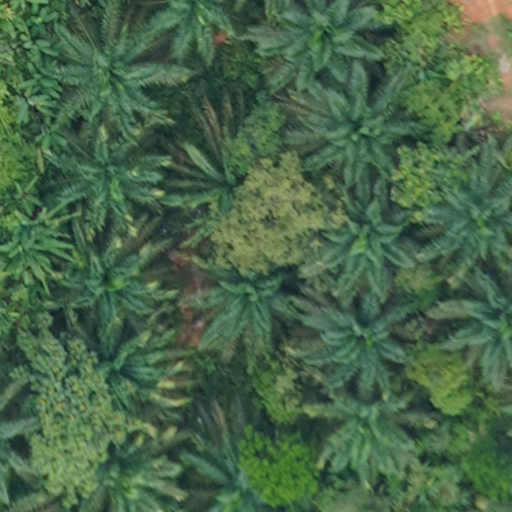

In [53]:
Image.open(img_path)

In [44]:
anns = list(sorted(os.listdir(os.path.join(ROOT_DIR, dataset_path/'label'))))

In [50]:
ann_path = os.path.join(ROOT_DIR, dataset_path/'label', anns[idx])
ann_path

'/home/amrirasyidi/projects/sawit_counting/test_patch/label/100_lbl.tif'

In [55]:
ann = Image.open(ann_path)

In [56]:
torch.as_tensor(ann['boxes'], dtype=torch.float32)

TypeError: 'TiffImageFile' object is not subscriptable

In [21]:
# Define dataloader's collate function
def my_collate_fn(batch):
    return tuple(zip(*batch))

In [22]:
# Load datasets to dataloaders
data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, collate_fn=my_collate_fn)
data_loader_val = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True, collate_fn=my_collate_fn)

In [23]:
def build_model(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [24]:
# Set caculating deivce
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"training device is {device}")

# Set classes number (should include background here)
num_classes = 2

# Get the model using our helper function
model = build_model(num_classes)

# Move model to device
model.to(device)

# Construct an optimizer
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model_parameters, lr=0.0001, momentum=0.9, weight_decay=0.0005)

# Set a learning rate scheduler (defualt value is a constant learning rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)

training device is cuda


In [26]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    lr_scheduler = None
    
    # Build a dictionary to recored losses
    LOSS = {
        'loss_classifier':[],
        'loss_box_reg':[],
        'loss_mask':[],
        'loss_objectness':[],
        'loss_rpn_box_reg':[],
        'loss_sum':[]
    }
    
    # Warm up the model in the first epoch
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
        
    # Training process
    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        for i in loss_dict.keys():
            LOSS[i].append(loss_dict[i].item())    
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        LOSS['loss_sum'].append(loss_value)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    return LOSS

In [27]:
def val_one_epoch(model, data_loader, device, epoch):
    # Build a dictionary to recored losses
    LOSS = {
        'val_loss_classifier':[],
        'val_loss_box_reg':[],
        'val_loss_mask':[],
        'val_loss_objectness':[],
        'val_loss_rpn_box_reg':[],
        'val_loss_sum':[]
    }
    
    # Speed up evaluation by not computing gradients
    with torch.no_grad():
        model.train()
        
        # Evaluating process
        for images, targets in tqdm(data_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            for i in loss_dict.keys():
                LOSS["val_"+i].append(loss_dict[i].item())    
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            LOSS['val_loss_sum'].append(loss_value)

    return LOSS

In [29]:
# Name the model
model_name = "my_model"

# Build a dictionary to recored losses
LOSSES = {
        'loss_classifier':[],
        'loss_box_reg':[],
        'loss_mask':[],
        'loss_objectness':[],
        'loss_rpn_box_reg':[],
        'loss_sum':[],
        'val_loss_classifier':[],
        'val_loss_box_reg':[],
        'val_loss_mask':[],
        'val_loss_objectness':[],
        'val_loss_rpn_box_reg':[],
        'val_loss_sum':[]
    }

# Declare the checkpoint saving paths
PATH = 'checkpoints/' + model_name + '_checkpoint.pt'
min_PATH = 'checkpoints/' + model_name + '_checkpoint_min.pt'

# Declare a minimum loss value to ensure whether the current epoch has the minimum loss
min_loss = None

# Set the training epochs number
num_epochs = 3

In [30]:
# Training process
for epoch in range(num_epochs):
        print(f"epoch {epoch} is training - learning rate = {lr_scheduler.get_last_lr()[0]}")  
        # Train for one epoch and recored train losses
        LOSSES_train = train_one_epoch(model, optimizer, data_loader_train, device, epoch)
        
        # Update the learning rate
        lr_scheduler.step()
        
        print(f"epoch {epoch} is validating")
        # valid for one epoch and recored valid losses
        LOSSES_val = val_one_epoch(model, data_loader_val, device, epoch)
        
        # Draw and save the loss curve
        plt.figure(epoch)
        plt.suptitle(f"Training Loss till epoch {epoch}")
        
        for i, v in enumerate(LOSSES_train.keys()):
            LOSSES[v].append(sum(LOSSES_train[v])/len(LOSSES_train[v]))
            plt.subplot(3, 2, i+1)
            plt.plot(LOSSES[v], label=v, color='b')
            plt.title(v)
        
        for i, v in enumerate(LOSSES_val.keys()):
            LOSSES[v].append(sum(LOSSES_val[v])/len(LOSSES_val[v]))
            plt.subplot(3, 2, i+1)
            plt.plot(LOSSES[v], label=v, color='r')
            plt.legend(fontsize='xx-small', loc='upper right') 
        
        plt.tight_layout()
        plt.savefig('losses_curves/' + model_name + "_losses_curve.png", dpi=600)
        plt.show()
        
        # Print out current train loss and valid loss
        print(f"train loss sum = {sum(LOSSES_train['loss_sum'])/len(LOSSES_train['loss_sum'])}")
        print(f"valid loss sum = {sum(LOSSES_val['val_loss_sum'])/len(LOSSES_val['val_loss_sum'])}\n")
        
        # If the loss for the current epoch is minimal, save it to the checkpoint
        if not min_loss or LOSSES['val_loss_sum'][-1] < min_loss:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': LOSSES,
                    }, min_PATH)
            min_loss = LOSSES['val_loss_sum'][-1]
        
        # Save training datas to the checkpoint every 5 epoch
        if (epoch+1)%5 == 0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': LOSSES,
                    }, PATH)

epoch 0 is training - learning rate = 0.0001


  0%|          | 0/192 [00:00<?, ?it/s]

UnpicklingError: Failed to interpret file '/home/amrirasyidi/projects/sawit_counting/test_patch/label/227_lbl.tif' as a pickle